<a href="https://colab.research.google.com/github/lapluu/Coursera-getting-and-cleaning-data-project/blob/master/LinearRegFinal4_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 26.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging
import tensorflow as tf
import keras_tuner as kt
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.python.keras.layers import LSTM, Dense, Dropout
from tensorflow.python.keras.callbacks import EarlyStopping
#from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization
import json
from datetime import datetime

logging.basicConfig(level=logging.INFO)

Using TensorFlow backend


In [ ]:
INPUT_DATA_FILE = '/content/drive/My Drive/Anyfile Notepad Files/AAPL_2013_2023_10_04.csv'

def load_and_preprocess_data(filename):
    df = pd.read_csv(filename).dropna()
    logging.info("Data loaded successfully.")
    df["Date"] = pd.to_datetime(df["Date"])
    close_prices = df[["Date", "Close"]].copy()
    close_prices.columns = ["ds", "y"]
    close_prices.set_index("ds", inplace=True)
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_prices_scaled = scaler.fit_transform(close_prices)
    logging.info("Data normalized.")
    return df, close_prices, close_prices_scaled, scaler

df, close_prices, close_prices_scaled, scaler = load_and_preprocess_data(INPUT_DATA_FILE)


version 4_6: Sept 22,2023
- Split data into (70%, 20%, 10%) for train,valuatiton, test sets.

Split data into ( 70%, 20 %, 10%) for train, eval,test sets

In [ ]:
TIMESTEPS = 60

def split_data(data, timesteps):
    if len(data) != 0:
       # Adjust the length of data so that its total length is a multiple of TIMESTEPS
       remainder = len(data) % TIMESTEPS
       if remainder != 0:
                data2 = data[remainder:] # drop the earliest data
       # Split the adjusted data into train, evaluation and test
       Y_units = len(data2) // timesteps
       test_units = Y_units * 10 // 100  # 10 %
       eval_units = Y_units * 20 // 100  # 20%
       train_size = (Y_units - (test_units + eval_units)) * timesteps # 70%
       test_data = data2[-test_units * timesteps:] # 10 %
       eval_data = data2[-(test_units + eval_units) * timesteps:-test_units * timesteps] # 20%
       train_data = data2[:-(test_units + eval_units) * timesteps] # 70%
       logging.info(f"Training data size: {train_size} / {len(data2)} ")

       return train_data, eval_data, test_data, train_size
    else:
        raise Exception('Data set is empty, cannot split.')

train_data, valuation_data, test_data, train_size = split_data(close_prices_scaled,TIMESTEPS)

In [ ]:
close_prices_scaled.shape, train_data.shape, valuation_data.shape, test_data.shape, train_size


((2516, 1), (1740, 1), (480, 1), (240, 1), 1740)

In [ ]:
rem = len(close_prices_scaled) % 60
rem

56

In [ ]:
close_re = close_prices_scaled[rem:]
close_re.shape

(2460, 1)

In [ ]:
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i - look_back: i, 0])
        Y.append(data[i, 0])
    X, Y = np.array(X), np.array(Y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, Y

X_train, Y_train = create_dataset(train_data, TIMESTEPS)
X_valuation, Y_valuation = create_dataset(valuation_data, TIMESTEPS)
X_test, Y_test = create_dataset(test_data, TIMESTEPS)

In [ ]:
X_train.shape,train_size,X_valuation.shape,X_test.shape

((1680, 60, 1), 1740, (420, 60, 1), (180, 60, 1))

In [ ]:
SELECTED_TUNER = "RandomSearch"  # Options: "RandomSearch", "Hyperband", "BayesianOptimization"
TUNER_SAVED_MODEL_PATH = '/content/drive/MyDrive/project/'
TUNER_PROJECT_NAME = 'Stock Price LSTM'
SEARCH_OBJECTIVE = "val_loss"

def build_model(hp, input_shape):
    model = keras.Sequential()
    model.add(LSTM(units=hp.Int('units_input', min_value=32, max_value=256, step=32),
                   return_sequences=True, input_shape=input_shape))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_hidden', min_value=32, max_value=256, step=32), return_sequences=True))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units_output', min_value=32, max_value=256, step=32)))
    model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.mean_squared_logarithmic_error)
    return model

def get_tuner(name, input_shape,search_objective, tuner_directory, tuner_project_name):
    if name == "RandomSearch":
        return kt.RandomSearch(lambda hp: build_model(hp, input_shape), objective='val_loss', max_trials=5, overwrite=False,
                            executions_per_trial=3, directory=tuner_directory, project_name=tuner_project_name)
    elif name == "Hyperband":
        return kt.Hyperband(lambda hp: build_model(hp, input_shape), objective='val_loss', max_epochs=100, overwrite=False,
                         max_retries_per_trial=1, executions_per_trial=2, directory=tuner_directory, project_name=tuner_project_name)
    elif name == "BayesianOptimization":
        return kt.BayesianOptimization(lambda hp: build_model(hp, input_shape), objective='val_loss', max_trials=10, overwrite=False,
                                    directory=tuner_directory, project_name=tuner_project_name)
    else:
        raise ValueError(f"Unsupported tuner: {name}")




tuner = get_tuner(SELECTED_TUNER, (X_train.shape[1], 1), TUNER_SAVED_MODEL_PATH, TUNER_PROJECT_NAME, SEARCH_OBJECTIVE)

tuner.search_space_summary()

Search space summary
Default search space size: 7
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
units_output (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
early_stop = EarlyStopping(monitor=SEARCH_OBJECTIVE, patience=15)
tuner.search(X_train, Y_train, epochs=60, batch_size=32, validation_data=(X_valuation, Y_valuation), callbacks=[early_stop])

Trial 1 Complete [00h 35m 36s]
val_loss: 0.3070196509361267

Best val_loss So Far: 0.3070196509361267
Total elapsed time: 00h 35m 36s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
96                |224               |units_input
0.3               |0.4               |dropout_1
256               |256               |units_hidden
0                 |0.2               |dropout_2
160               |224               |units_output
0.1               |0.4               |dropout_3
0.0001            |0.01              |learning_rate

Epoch 1/60
53/53 [==============================] - 53s 819ms/step - loss: 0.0060 - val_loss: 7.2031e-04
Epoch 2/60
53/53 [==============================] - 42s 804ms/step - loss: 2.5698e-04 - val_loss: 0.0011
Epoch 3/60
53/53 [==============================] - 43s 805ms/step - loss: 2.4194e-04 - val_loss: 6.9079e-04
Epoch 4/60
53/53 [==============================] - 42s 800ms/step - loss: 2.1628e-04 - val_loss: 0.0013
Epoch 5/60
53

KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()

Results summary
Results in Stock Price LSTM/val_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 00 summary
Hyperparameters:
units_input: 128
dropout_1: 0.0
units_hidden: 256
dropout_2: 0.2
units_output: 32
dropout_3: 0.1
Score: 0.00014547299360856414

Trial 08 summary
Hyperparameters:
units_input: 32
dropout_1: 0.0
units_hidden: 192
dropout_2: 0.2
units_output: 224
dropout_3: 0.2
Score: 0.00016066874377429485

Trial 06 summary
Hyperparameters:
units_input: 256
dropout_1: 0.2
units_hidden: 160
dropout_2: 0.1
units_output: 192
dropout_3: 0.30000000000000004
Score: 0.00017349929839838296

Trial 03 summary
Hyperparameters:
units_input: 160
dropout_1: 0.2
units_hidden: 224
dropout_2: 0.2
units_output: 224
dropout_3: 0.30000000000000004
Score: 0.00017402703815605491

Trial 05 summary
Hyperparameters:
units_input: 192
dropout_1: 0.1
units_hidden: 32
dropout_2: 0.1
units_output: 96
dropout_3: 0.1
Score: 0.00018804958381224424

Trial 07 summary
Hyperparameters:
un

In [ ]:
# Retrieve and print the best model from tuner
tuner_best_model = tuner.get_best_models(num_models=1)[0]
tuner_best_model.build(input_shape=(None,28,28))
tuner_best_model.summary()

    # Retrieve and print the best hyperparameters.
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hps.get_config())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 60, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 256)           394240    
                                                                 
 dropout_1 (Dropout)         (None, 60, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 32)                36992     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 3

In [ ]:
SAVED_OUTPUT_DATA_PATH = '/content/drive/My Drive/Anyfile Notepad Files/'

def save_hyperparameters_to_file(hps, filename):
    with open(filename, 'w') as f:
        json.dump(hps.get_config(), f)


# saved the hyperparameters to file.
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{SAVED_OUTPUT_DATA_PATH}hyperparameters_{timestamp}.json"
save_hyperparameters_to_file(best_hps, filename)

In [ ]:
N_FUTURE = 20


def generate_forecasts(n_future, X, Y, model, scaler):
    """
    Generates multi-step forecasts using a trained model.

    Parameters:
    - n_future (int): Number of future time steps to predict.
    - X (np.ndarray): Input sequences for the model.
    - Y (np.ndarray): Corresponding target values for the input sequences.
    - model (tf.keras.Model): Trained forecasting model.
    - scaler (scikit-learn scaler): Scaler used to scale the data.

    Returns:
    - y_future_rescaled (np.ndarray): Forecasted values in the original scale.
    """

    y_future = []

    x_pred = X[-1:, :, :]  # last observed input sequence
    y_pred = Y[-1]  # last observed target value

    for _ in range(n_future):
        # feed the last forecast back to the model as an input
        x_pred = np.append(x_pred[:, 1:, :], y_pred.reshape(1, 1, 1), axis=1)

        # generate the next forecast
        y_pred = model.predict(x_pred)

        # save the forecast
        y_future.append(y_pred.flatten()[0])

    # transform the forecasts back to the original scale
    y_future_array = np.array(y_future).reshape(-1, 1)
    y_future_rescaled = scaler.inverse_transform(y_future_array)

    return y_future_rescaled


y_pred = tuner_best_model.predict(X_test)
y_future_rescaled = generate_forecasts(N_FUTURE, X_test, y_pred, tuner_best_model, scaler)

y_pred_rescaled = scaler.inverse_transform(y_pred)
Y_test_rescaled = scaler.inverse_transform([Y_test])

Predicted with the model object which is built by build_model function, not from the get_best_model from the tuner.

In [ ]:
def create_future_dates(yyyymmdd, n_future):
    date = pd.to_datetime(yyyymmdd)
    next_date = date + pd.Timedelta(days=1)
    future_days =  pd.DataFrame(pd.date_range(start=next_date, periods=n_future ),
                                columns=['Date'])
    return future_days

def save_forecast_to_csv(close_prices_df, y_future, n_future, suffic):
    # Extracting the last date
    last_date = close_prices_df.index[-1]
    next_date = last_date + pd.Timedelta(days=1)
    future_dates = pd.date_range(start=next_date, periods=n_future)
    # Creating the DataFrame for future dates
    forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Close': y_future.flatten()})

    # Setting the filename as per the given rules
    base_name = INPUT_DATA_FILE.split('.')[0]
    #file_name = f"{base_name}_fut_{n_future}.csv"
    file_name = f"{base_name}{suffic}{n_future}.csv"

    # Saving the DataFrame to a CSV file
    forecast_df.to_csv(file_name, index=False)
    logging.info(f"Forecasted data saved to {file_name}")


def evaluate_model(Y_test, y_pred):
    mse = mean_squared_error(Y_test[0], y_pred)
    msle = mean_squared_log_error(Y_test[0], y_pred)
    mae = mean_absolute_error(Y_test[0], y_pred)
    r2 = r2_score(Y_test[0], y_pred)

    print('MSE: ', mse)
    print('MSLE: ', msle)
    print('MAE: ', mae)
    print('R-squared: ', r2)

TUNER_SUFFIX = '_T_FUT_'
evaluate_model(Y_test_rescaled, y_pred_rescaled)
save_forecast_to_csv(close_prices, y_future_rescaled, N_FUTURE, TUNER_SUFFIX)


MSE:  14.78058903865821
MSLE:  0.0006034633172605782
MAE:  3.0707207910486165
R-squared:  0.9460051064019346


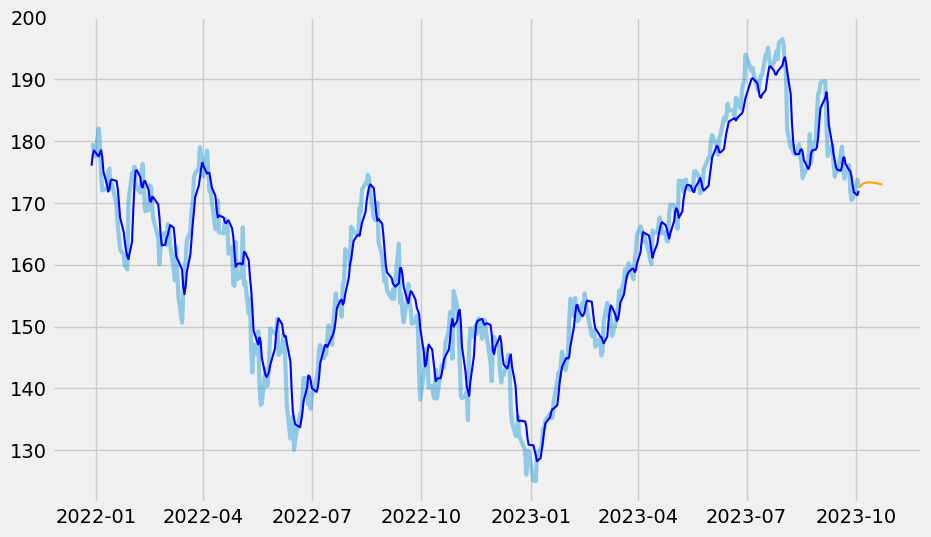

In [ ]:
def plot_predictions(df, train_size,n_future, look_back, Y_test, y_pred,y_future):
    #future_dates = pd.date_range(df["Date"][train_size + look_back:].iloc[-1], periods=n_future + 1)[:-1]
    last_date = df["Date"][train_size + look_back:].iloc[-1]
    future_dates = create_future_dates(last_date, n_future)

    plt.figure(figsize=(10, 6))
    plt.style.use('fivethirtyeight')
    plt.plot(df["Date"][train_size + look_back:], Y_test.flatten(), label="Actual", linewidth=3, alpha=0.4)
    plt.plot(df["Date"][train_size + look_back:], y_pred.flatten(), label="Predicted", linewidth=1.5, color='blue')
    plt.plot(future_dates, y_future.flatten(), label="Future", linewidth=1.5, color='orange')
  #plt.plot(df["Date"][train_size + look_back:], y_future.flatten(), label="Future", linewidth=1.5, color='green')


plot_predictions(df, train_size, N_FUTURE, LOOK_BACK, Y_test_rescaled, y_pred_rescaled,y_future_rescaled)

Now, try to rebuilt the model object from the best hyperparameters;rather than get the best model object from the tuner.

In [ ]:
# Build the model with the best hp.
built_model = build_model(best_hps, (X_train.shape[1], 1))
# Fit with the entire dataset.
x_all = np.concatenate((X_train, X_test))
y_all = np.concatenate((Y_train, Y_test))
built_model.fit(x=x_all, y=y_all, epochs=1)

75/75 [==============================] - 7s 13ms/step - loss: 0.0035


Using this built model object to forecast the future

In [ ]:
y_pred2 = built_model.predict(X_test)
y_future2_rescaled = generate_forecasts(N_FUTURE, X_test, y_pred2, built_model, scaler)
y_pred2_rescaled = scaler.inverse_transform(y_pred2)

Do the same to evaluate the errors metric and save it to file


In [ ]:
TUNER_SUFFIX = '_M_FUT_'  # model's forecast future data

evaluate_model(Y_test_rescaled, y_pred2_rescaled)
save_forecast_to_csv(close_prices, y_futur2_rescaled, N_FUTURE)


Plot the forecast to the graph


In [ ]:
plot_predictions(df, train_size, N_FUTURE, LOOK_BACK, Y_test_rescaled, y_pred2_rescaled,y_future2_rescaled)